In [1]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
from numba import njit, prange
from os import listdir
from os.path import isfile, join

%matplotlib inline
plt.style.use(['science','ieee'])

# IMPORT THE TRAINING DATA

In [2]:
for i in range(0,24):
    if i < 12:
        df = pd.read_csv('../data/training_data/' + str(i) + '.csv')
    else:
        df = pd.read_csv('../data/training_data/s' + str(i-12) + '.csv')
    throttle = df.throttle
    brake = df.brake
    exec("t{} = np.array(df.t).astype('float64')".format(i))
    exec("u{} = np.array([throttle, brake]).T.astype('float64')".format(i))
    exec("v{} = np.array(df.v).astype('float64')".format(i))

# MAKE FUNCTION

## Generate population

In [3]:
def generate_population(num, dim, rng):
    """
    Generate population:
        Input:
            num: number of population (integer)
            dim: number of parameters (integer)
            rng: range number used in initialization (list or numpy array)
        Output:
            pop: initial position of the population (numpy array)
    """
    pop = np.zeros((num,dim))
    for i in range(dim):
        lim = rng[i]
        pop[:, i] = np.random.uniform(lim[0], lim[1], size=num)
    return pop

## Constraint

In [4]:
ndim = 17
@njit
def admissible(param):
    a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param
    if a1 > 0. or a2 > 0. or a3 > 0. or b1 < 0. or b2 < 0. or c1 > 0. or c2 > 0. or np.around(td11)<0 or np.around(td12)<0 or np.around(td13)<0 or np.around(td21)<0 or np.around(td22)<0 or np.around(td23)<0:
        return False
    else:
        return True
    
_ = admissible(np.random.randn(ndim))

## Forward propagation

In [5]:
@njit
def delayed_control_signal(i, u, u_list, td):
    if i < td:
        ut = 0.0
    else:
        if td == 0:
            ut = u
        else:
            ut = u_list[i-td]
    return ut
_ = delayed_control_signal(1, 0.1, np.array([0.1, 0.2]), 0)

In [6]:
@njit
def forward_propagation(t, u, param):
    a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param
    td11 = int(np.around(td11))
    td12 = int(np.around(td12))
    td13 = int(np.around(td13))
    td21 = int(np.around(td21))
    td22 = int(np.around(td22))
    td23 = int(np.around(td23))

    u1_list = np.empty(t.shape)
    u2_list = np.empty(t.shape)
    out = np.empty(t.shape)
    y = 0.0
    for i in range(t.shape[0]):
        if i == 0:
            dt = t[1] - t[0]
        else:
            dt = t[i] - t[i-1]
            
        u1, u2 = u[i]        
        u11t = delayed_control_signal(i, u1, u1_list, td11)
        u12t = delayed_control_signal(i, u1, u1_list, td12)
        u13t = delayed_control_signal(i, u1, u1_list, td13)
        u21t = delayed_control_signal(i, u2, u2_list, td21)
        u22t = delayed_control_signal(i, u2, u2_list, td22)
        u23t = delayed_control_signal(i, u2, u2_list, td23)
        
        temp = 0.
        if y != 0.:
            temp = a1
                    
        y_dot = temp + a2 * y + a3 * y**2 \
                + b1 * u11t + b2 * np.exp(b3 * y + b4 * u12t) * u13t \
                + c1 * u21t + c2 * np.exp(c3 * y + c4 * u22t) * u23t
        
        y += y_dot * dt
        if y < 0.0:
            y = 0.0

        u1_list[i] = u1
        u2_list[i] = u2
        out[i] = y

    return out
_ = forward_propagation(np.arange(10, dtype=float), np.random.randn(10,2), np.ones(ndim))

## Cost and metric

In [7]:
@njit
def cost(t, u, v, param):
    error = (v - forward_propagation(t, u, param))
    cost = np.dot(error.T, error)
    return cost
_ = cost(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

@njit
def accuracy(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    numerator = np.linalg.norm(error)
    denumerator = np.linalg.norm(v - np.mean(v))
    acc = 1.0 - numerator / denumerator
    return acc
_ = accuracy(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

@njit
def mean_absolute_error(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    out = np.mean(np.abs(error))
    return out
_ = mean_absolute_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

@njit
def mean_squared_error(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    out = np.mean(error**2)
    return out
_ = mean_squared_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

@njit
def maximum_absolute_error(t, u, v, param):
    error = v - forward_propagation(t, u, param)
    out = np.max(np.abs(error))
    return out
_ = maximum_absolute_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(ndim))

In [8]:
for i in range(0,24):
    if i < 12:
        df = pd.read_csv('../data/training_data/' + str(i) + '.csv')
    else:
        df = pd.read_csv('../data/training_data/s' + str(i-12) + '.csv')
    throttle = df.throttle
    brake = df.brake
    exec("t{} = np.array(df.t).astype('float64')".format(i))
    exec("u{} = np.array([throttle, brake]).T.astype('float64')".format(i))
    exec("v{} = np.array(df.v).astype('float64')".format(i))

In [9]:
gain = np.array([1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0,
                 1.0, 1.0, 1.0])

@njit
def calculate_total_cost(param):
    loss = np.Inf
    if admissible(param):
        loss = 0.
        m = 0.
        
        loss += cost(t0, u0, v0, param) * gain[0]
        loss += cost(t1, u1, v1, param) * gain[1]
        loss += cost(t2, u2, v2, param) * gain[2]
        loss += cost(t3, u3, v3, param) * gain[3]
        loss += cost(t4, u4, v4, param) * gain[4]
        loss += cost(t5, u5, v5, param) * gain[5]
        loss += cost(t6, u6, v6, param) * gain[6]
        loss += cost(t7, u7, v7, param) * gain[7]
        loss += cost(t8, u8, v8, param) * gain[8]
        loss += cost(t9, u9, v9, param) * gain[9]
        loss += cost(t10, u10, v10, param) * gain[10]
        loss += cost(t11, u11, v11, param) * gain[11]
        loss += cost(t12, u12, v12, param) * gain[12]
        loss += cost(t13, u13, v13, param) * gain[13]
        loss += cost(t14, u14, v14, param) * gain[14]
        loss += cost(t15, u15, v15, param) * gain[15]
        loss += cost(t16, u16, v16, param) * gain[16]
        loss += cost(t17, u17, v17, param) * gain[17]
        loss += cost(t18, u18, v18, param) * gain[18]
        loss += cost(t19, u19, v19, param) * gain[19]
        loss += cost(t20, u20, v20, param) * gain[20]
        loss += cost(t21, u21, v21, param) * gain[21]
        loss += cost(t22, u22, v22, param) * gain[22]
        loss += cost(t23, u23, v23, param) * gain[23]

        m += t0.shape[0] * gain[0]
        m += t1.shape[0] * gain[1]
        m += t2.shape[0] * gain[2]
        m += t3.shape[0] * gain[3]
        m += t4.shape[0] * gain[4]
        m += t5.shape[0] * gain[5]
        m += t6.shape[0] * gain[6]
        m += t7.shape[0] * gain[7]
        m += t8.shape[0] * gain[8]
        m += t9.shape[0] * gain[9]
        m += t10.shape[0] * gain[10]
        m += t11.shape[0] * gain[11]
        m += t12.shape[0] * gain[12]
        m += t13.shape[0] * gain[13]
        m += t14.shape[0] * gain[14]
        m += t15.shape[0] * gain[15]
        m += t16.shape[0] * gain[16]
        m += t17.shape[0] * gain[17]
        m += t18.shape[0] * gain[18]
        m += t19.shape[0] * gain[19]
        m += t20.shape[0] * gain[20]
        m += t21.shape[0] * gain[21]
        m += t22.shape[0] * gain[22]
        m += t23.shape[0] * gain[23]

        loss = loss / m
        
    return loss
_ = calculate_total_cost(np.ones(ndim))

In [10]:
@njit
def population_cost(population):
    length = population.shape[0]
    losses = np.empty(length)
    
    for ii in range(length):
        losses[ii] = calculate_total_cost(population[ii])
    return losses
_ = population_cost(np.ones((2,ndim)))

## APSO

In [11]:
@njit
def apso(population, loss_population, global_, global_loss, alpha0, beta):
    num = population.shape[0]
    dim = population.shape[1]
    
    # Initial conditions
    ppos_vector = np.copy(population)
    pbest_pos = np.copy(ppos_vector)
    pfit_value = np.copy(loss_population)
    gbest_pos = np.copy(global_)
    gfit_value = global_loss
    
    L = np.empty_like(population[0])
    for i in range(L.shape[0]):
        L[i] = np.max(population[:, i]) - np.min(population[:, i])
    
    for i in range(num):
        # Update the alpha value
        alpha = alpha0 * L
            
        # Update the velocity and position vector
        ppos_vector[i] = (1-beta)*ppos_vector[i] + alpha*np.random.normal(0,1) + beta*gbest_pos
        
        cost_func = calculate_total_cost(ppos_vector[i])
        
        # Update each values using the cost functions
        if(pfit_value[i] > cost_func):
            pfit_value[i] = cost_func
            pbest_pos[i] = np.copy(ppos_vector[i])
                
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
    
    return pbest_pos, pfit_value, gbest_pos, gfit_value
    
xx1 = np.ones((2, ndim))*1.0
xx2 = np.ones(2)
xx3 = np.ones(ndim)*0.5
_ = apso(xx1, xx2, xx3, 100.0, 0.8, 1.5)

# SIMULATION (OPTIMIZATION)

In [12]:
num = 50
n_sim = 20
n_itr = 10000

r_a1 = [0., -2.]
r_a2 = [0., -2.]
r_a3 = [0., -2.]
r_b1 = [0., 2.]
r_b2 = [0., 2.]
r_b3 = [-2., 2.]
r_b4 = [-2., 2.]
r_c1 = [0., -2.]
r_c2 = [0., -2.]
r_c3 = [-2., 2.]
r_c4 = [-2., 2.]
r_td11 = [0, 15]
r_td12 = [0, 15]
r_td13 = [0, 15]
r_td21 = [0, 6]
r_td22 = [0, 6]
r_td23 = [0, 6]
rng = [r_a1, r_a2, r_a3,
       r_b1, r_b2, r_b3, r_b4,
       r_c1, r_c2, r_c3, r_c4,
       r_td11, r_td12, r_td13,
       r_td21, r_td22, r_td23
      ]
dim = len(rng)

alpha0 = 0.8
beta = 0.15

In [13]:
param_history = np.zeros((n_sim, dim))
loss_history = np.ones(n_sim) * np.Inf

the_best_param_history = np.zeros((n_itr, dim))
the_best_loss_history = np.zeros(n_itr)

for j in range(n_sim):
    population = generate_population(num, dim, rng)
    rng_vel = [[-max([abs(rng[i][0]), abs(rng[i][1])]), max([abs(rng[i][0]), abs(rng[i][1])])] for i in range(len(rng))]
    pop_velocity = generate_population(num, dim, rng_vel)
    global_ = None
    global_loss_ = np.Inf
    
    loss_population = population_cost(population)
    loss_population[np.isnan(loss_population)] = np.Inf
    min_idx = np.argmin(loss_population)
    min_loss = loss_population[min_idx]
    if global_loss_ > min_loss:
        global_loss_ = min_loss
        global_ = np.copy(population[min_idx, :])
        
    global_history = np.empty((n_itr, dim))
    global_history[0] = global_
    global_loss_history = np.empty(n_itr)
    global_loss_history[0] = global_loss_
    for i in range(1, n_itr):
        # Accelerated Particle Swarm Optimization
        population, loss_population, global_, global_loss_ = apso(population, loss_population, global_, global_loss_, alpha0, beta)
        
        if (i-1) % 500 == 0:
            print('simulation: {} || iteration: {} || global_loss: {:.5f}'.format(j+1, i, global_loss_))

        global_history[i] = global_
        global_loss_history[i] = global_loss_
    
    if np.min(loss_history) > global_loss_history[-1]:
        the_best_loss_history = np.copy(global_loss_history)
        the_best_param_history = np.copy(global_history)
        
    param_history[j] = np.copy(global_history[-1])
    loss_history[j] = np.copy(global_loss_history[-1])
    
    print('simulation: {} || global loss: {:.10f} || the best loss: {:.10f}'.format(j, global_loss_history[-1], the_best_loss_history[-1]))

simulation: 1 || iteration: 1 || global_loss: 78.48047
simulation: 1 || iteration: 501 || global_loss: 3.63169
simulation: 1 || iteration: 1001 || global_loss: 1.71078
simulation: 1 || iteration: 1501 || global_loss: 1.71078
simulation: 1 || iteration: 2001 || global_loss: 1.71078
simulation: 1 || iteration: 2501 || global_loss: 1.69665
simulation: 1 || iteration: 3001 || global_loss: 1.69663
simulation: 1 || iteration: 3501 || global_loss: 1.67833
simulation: 1 || iteration: 4001 || global_loss: 1.66546
simulation: 1 || iteration: 4501 || global_loss: 1.64985
simulation: 1 || iteration: 5001 || global_loss: 1.64985
simulation: 1 || iteration: 5501 || global_loss: 1.64229
simulation: 1 || iteration: 6001 || global_loss: 1.64225
simulation: 1 || iteration: 6501 || global_loss: 1.64225
simulation: 1 || iteration: 7001 || global_loss: 1.64225
simulation: 1 || iteration: 7501 || global_loss: 1.64225
simulation: 1 || iteration: 8001 || global_loss: 1.64225
simulation: 1 || iteration: 8501 |

In [14]:
# Save the simulation
np.save('result/param_history.npy', param_history)
np.save('result/loss_history.npy', loss_history)
np.save('result/the_best_loss_history.npy', the_best_loss_history)
np.save('result/the_best_param_history.npy', the_best_param_history)

In [15]:
f = open("result/sim.cfg", "w+")
f.writelines('num: {} # The number of particles\n'.format(num))
f.writelines('n_sim: {} # The number of simulation loop\n'.format(n_sim))
f.writelines('n_itr: {} # The number of iteration for each simulation\n'.format(n_itr))
f.writelines('\n# The boundary of the initialization value\n')
f.writelines('\tr_a1: {}\n'.format(r_a1))
f.writelines('\tr_a2: {}\n'.format(r_a2))
f.writelines('\tr_a3: {}\n'.format(r_a3))
f.writelines('\tr_b1: {}\n'.format(r_b1))
f.writelines('\tr_b2: {}\n'.format(r_b2))
f.writelines('\tr_b3: {}\n'.format(r_b3))
f.writelines('\tr_b4: {}\n'.format(r_b4))
f.writelines('\tr_c1: {}\n'.format(r_c1))
f.writelines('\tr_c2: {}\n'.format(r_c2))
f.writelines('\tr_c3: {}\n'.format(r_c3))
f.writelines('\tr_c4: {}\n'.format(r_c4))
f.writelines('\tr_td11: {}\n'.format(r_td11))
f.writelines('\tr_td12: {}\n'.format(r_td12))
f.writelines('\tr_td13: {}\n'.format(r_td13))
f.writelines('\tr_td21: {}\n'.format(r_td21))
f.writelines('\tr_td22: {}\n'.format(r_td22))
f.writelines('\tr_td23: {}\n'.format(r_td23))
f.writelines('\n# The gain of the dataset\n')
for i in range(gain.shape[0]):
    f.writelines('\tdata-{}: {}\n'.format(i, gain[i]))
f.writelines('\n# The PSO hyperparameters\n')
f.writelines('alpha0: {}\n'.format(alpha0))
f.writelines('beta: {}\n'.format(beta))
f.close()

# RESULT

## Load Model

In [16]:
# Load the model
the_best_param_history = np.load('result/the_best_param_history.npy')
the_best_loss_history = np.load('result/the_best_loss_history.npy')
global_ = the_best_param_history[-1]
global_loss_ = the_best_loss_history[-1]

In [17]:
param_name = ['a1', 'a2', 'a3', 'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4', 'd11', 'd12', 'd13', 'd21', 'd22', 'd23']
print('The minimum loss: {}'.format(global_loss_))
print('Parameters:')
for i in range(len(param_name)):
    print('{}: {}'.format(param_name[i], global_[i]))

The minimum loss: 0.5764779955273998
Parameters:
a1: -0.07188444497719766
a2: -0.6940262606437687
a3: -0.002585515763230664
b1: 1.6377880137474543
b2: 1.7170018158914329
b3: 0.03456071507617479
b4: 1.6323436974961654
c1: -0.12024906127290907
c2: -0.5542364436863219
c3: 0.2974277650683071
c4: 0.9864986301487715
d11: 16.869139002637848
d12: 10.737161426958226
d13: 11.414750990863709
d21: 2.793679288157061
d22: 3.7056408310066375
d23: 4.680891811086257


## Visualization

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


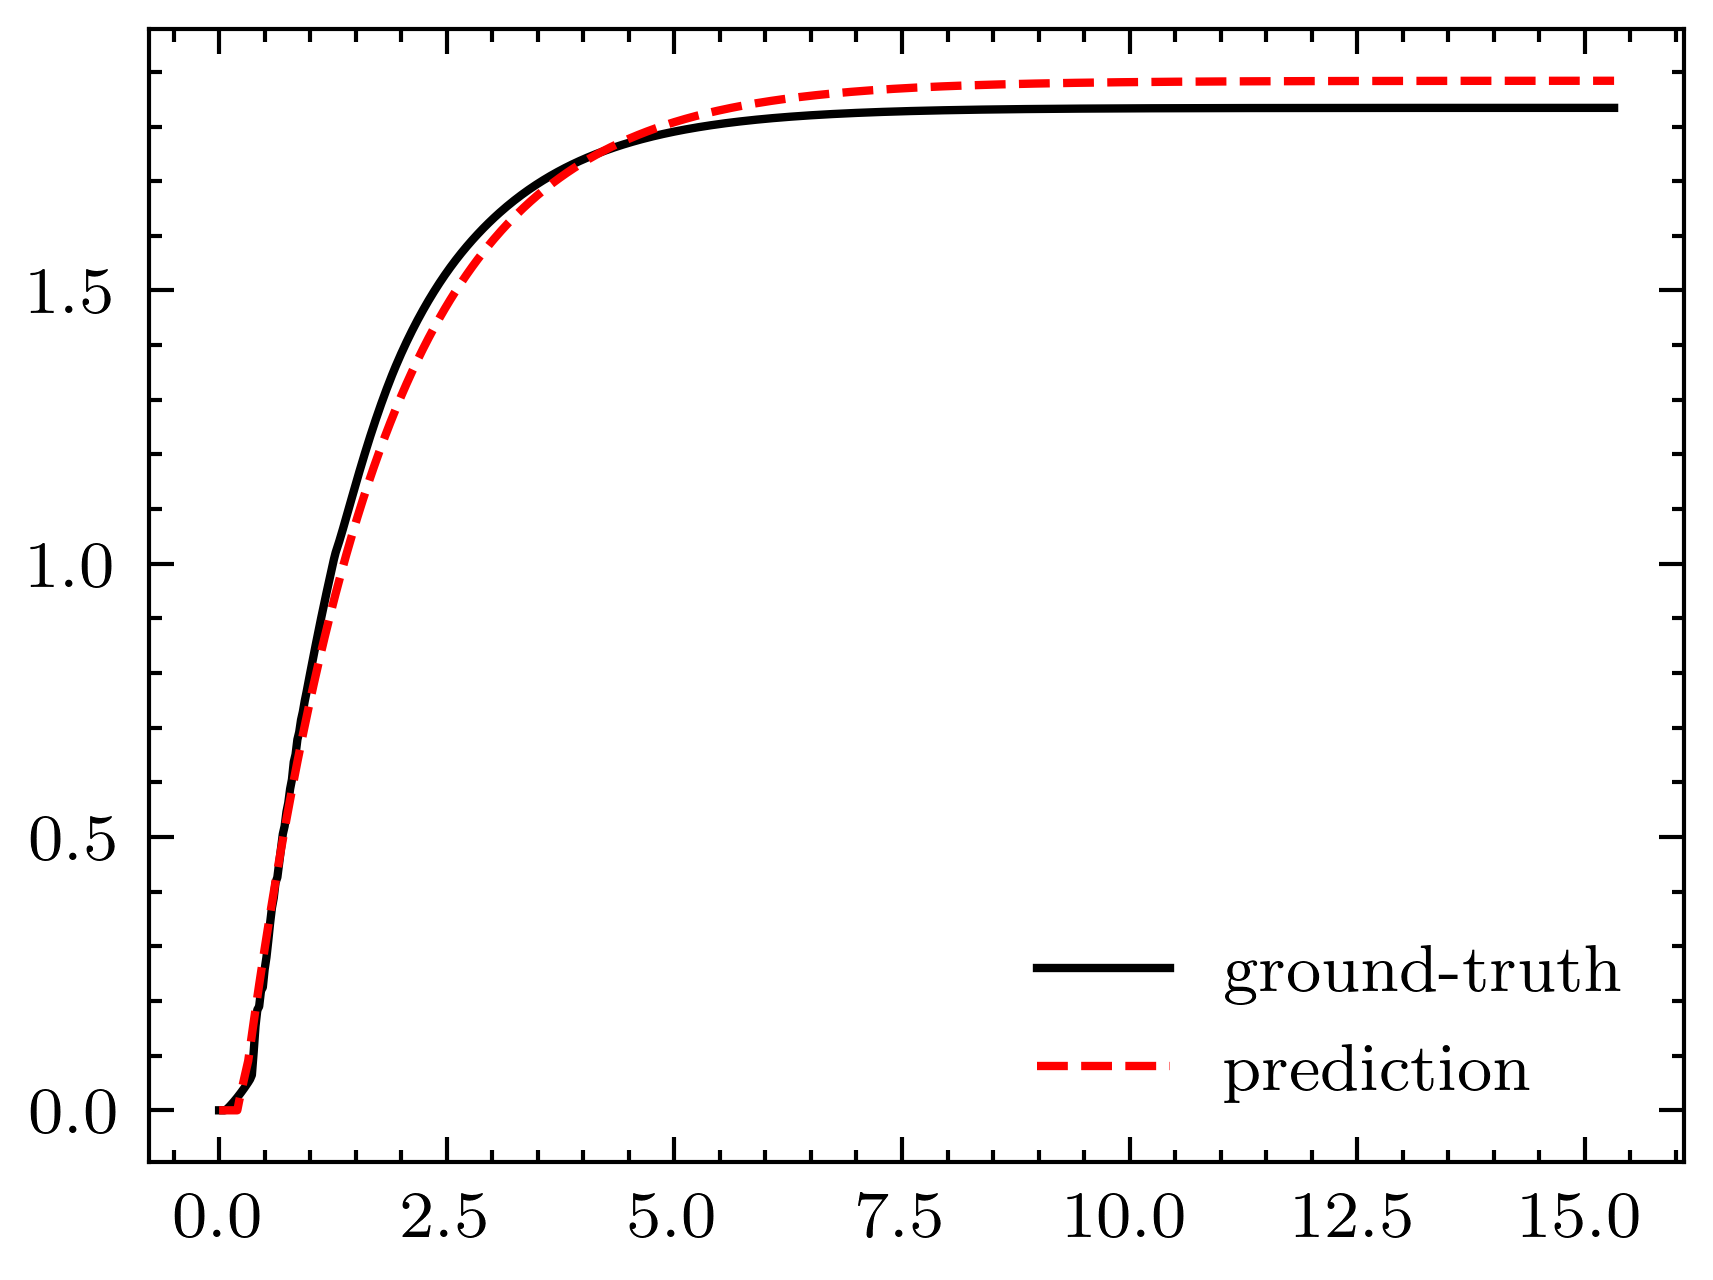

In [18]:
# Visualization
idx = 12
exec("t = np.copy(t{})".format(idx))
exec("u = np.copy(u{})".format(idx))
exec("v = np.copy(v{})".format(idx))
test = forward_propagation(t, u, global_)
plt.plot(t, v, label='ground-truth')
plt.plot(t, test, label='prediction')
plt.legend()
plt.show()

## Cost and Metrics

In [19]:
acc = []
mse = []
maae = [] 
for i in range(24):
    exec("acc.append(accuracy(t{}, u{}, v{}, global_))".format(i, i, i))
    exec("mse.append(mean_squared_error(t{}, u{}, v{}, global_))".format(i, i, i))
    exec("maae.append(maximum_absolute_error(t{}, u{}, v{}, global_))".format(i, i, i))

In [20]:
print('Accuracy')
for i in range(24):
    print('Data ke-{}: {:.2f}%'.format(i+1, acc[i]*100))

Accuracy
Data ke-1: 71.99%
Data ke-2: 82.51%
Data ke-3: 79.14%
Data ke-4: 78.07%
Data ke-5: 92.46%
Data ke-6: 85.77%
Data ke-7: 84.07%
Data ke-8: 89.65%
Data ke-9: 73.10%
Data ke-10: 80.92%
Data ke-11: 87.26%
Data ke-12: 82.43%
Data ke-13: 88.97%
Data ke-14: 87.58%
Data ke-15: 75.35%
Data ke-16: 87.26%
Data ke-17: 90.37%
Data ke-18: 82.01%
Data ke-19: 69.45%
Data ke-20: 70.97%
Data ke-21: 71.80%
Data ke-22: 71.74%
Data ke-23: 69.93%
Data ke-24: 69.31%


In [21]:
print('Mean Squared Error')
for i in range(24):
    print('Data ke-{}: {:.5f}'.format(i+1, mse[i]))

Mean Squared Error
Data ke-1: 0.08849
Data ke-2: 0.36753
Data ke-3: 0.96997
Data ke-4: 0.15975
Data ke-5: 0.04199
Data ke-6: 0.53031
Data ke-7: 0.79551
Data ke-8: 0.04264
Data ke-9: 0.05510
Data ke-10: 0.12593
Data ke-11: 0.17506
Data ke-12: 0.62701
Data ke-13: 0.00204
Data ke-14: 0.00574
Data ke-15: 0.05725
Data ke-16: 0.02770
Data ke-17: 0.02832
Data ke-18: 0.14020
Data ke-19: 0.48274
Data ke-20: 0.46350
Data ke-21: 0.78003
Data ke-22: 0.95311
Data ke-23: 1.43577
Data ke-24: 2.54581


In [22]:
print('Maximum Absolute Squared Error')
for i in range(24):
    print('Data ke-{}: {:.3f}'.format(i+1, maae[i]))

Maximum Absolute Squared Error
Data ke-1: 1.310
Data ke-2: 2.208
Data ke-3: 2.156
Data ke-4: 1.655
Data ke-5: 0.658
Data ke-6: 2.383
Data ke-7: 2.093
Data ke-8: 0.598
Data ke-9: 0.278
Data ke-10: 2.183
Data ke-11: 2.114
Data ke-12: 2.520
Data ke-13: 0.079
Data ke-14: 0.152
Data ke-15: 0.269
Data ke-16: 0.191
Data ke-17: 0.476
Data ke-18: 0.816
Data ke-19: 1.319
Data ke-20: 1.648
Data ke-21: 2.046
Data ke-22: 2.538
Data ke-23: 3.156
Data ke-24: 3.901


In [23]:
num = 0
for i in range(24):
    exec("num += t{}.shape[0]".format(i))
vv = np.empty(num)
vv_gt = np.empty(num)
nn = 0
for i in range(24):
    exec("n = t{}.shape[0]".format(i))
    exec("vv[nn: nn+n] = forward_propagation(t{}, u{}, global_)".format(i, i))
    exec("vv_gt[nn: nn+n] = v{}".format(i))
    nn += n
total_accuracy = (1 - np.linalg.norm(vv_gt - vv)/np.linalg.norm(vv_gt - np.mean(vv_gt)))
print('Total Accuracy: {:.2f}%'.format(total_accuracy*100))

Total Accuracy: 88.31%
